In [362]:
pip install kneed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [363]:
pip install clusteval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [364]:
# importing libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import MiniBatchKMeans,DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from kneed import KneeLocator
from clusteval import clusteval
from sklearn.decomposition import PCA
from datetime import date
from scipy.stats import probplot

## Defining the customization settings

In [365]:
plt.rcParams['figure.figsize'] = (12,8)
pd.set_option('display.float_format',lambda x: '%.2f' % x)

In [366]:
df = pd.read_csv('/content/bank_transactions.csv')
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.00
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.00
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.00
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.00
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.50


In [367]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


In [368]:
df.describe()

,CustAccountBalance,TransactionTime,TransactionAmount (INR)
count,1046198.00,1048567.00,1048567.00
mean,115403.54,157087.53,1574.34
std,846485.38,51261.85,6574.74
min,0.00,0.00,0.00
25%,4721.76,124030.00,161.00
50%,16792.18,164226.00,459.03
75%,57657.36,200010.00,1200.00
max,115035495.10,235959.00,1560034.99


In [369]:
df.isnull().sum()

TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64

In [370]:
df[df.duplicated()]

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)


## Feature Engineering

In [371]:
for col in df.columns:
    print("Percentage of null values of {}:".format(col),str(np.round(df[col].isna().sum()/len(df)*100,2)) + '%')

Percentage of null values of TransactionID: 0.0%
Percentage of null values of CustomerID: 0.0%
Percentage of null values of CustomerDOB: 0.32%
Percentage of null values of CustGender: 0.1%
Percentage of null values of CustLocation: 0.01%
Percentage of null values of CustAccountBalance: 0.23%
Percentage of null values of TransactionDate: 0.0%
Percentage of null values of TransactionTime: 0.0%
Percentage of null values of TransactionAmount (INR): 0.0%


In [372]:
for col in df.columns:
    print("Percentage of unique values of {}:".format(col),str(np.round(df[col].nunique()/len(df)*100,2)) + '%')

Percentage of unique values of TransactionID: 100.0%
Percentage of unique values of CustomerID: 84.33%
Percentage of unique values of CustomerDOB: 1.65%
Percentage of unique values of CustGender: 0.0%
Percentage of unique values of CustLocation: 0.89%
Percentage of unique values of CustAccountBalance: 15.39%
Percentage of unique values of TransactionDate: 0.01%
Percentage of unique values of TransactionTime: 7.81%
Percentage of unique values of TransactionAmount (INR): 8.87%


In [373]:
df = df[~df['CustomerDOB'].isna()]
df.CustomerDOB = pd.to_datetime(df.CustomerDOB,errors='coerce')

In [374]:
df.drop(df[df['CustGender'].isin(['T'])].index,axis=0,inplace=True)

In [375]:
df = df[~df['CustGender'].isna()]

In [376]:
df = df[~df['CustLocation'].isna()]

In [377]:
df.CustAccountBalance = df.CustAccountBalance.fillna(df.groupby('CustLocation')['CustAccountBalance'].transform('mean'))

In [378]:
df = df[~df.CustAccountBalance.isna()]

In [379]:
df = df.dropna()

In [380]:
df.isna().sum()

TransactionID              0
CustomerID                 0
CustomerDOB                0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
dtype: int64

In [381]:
def age(birthdate):
    today = date.today()
    age = today.year - birthdate.year - ((today.month, today.day) < (birthdate.month, birthdate.day))
    return age

In [382]:
df['Age'] = df.CustomerDOB.apply(age)

In [383]:
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),Age
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.00,27
1,T2,C2142763,2057-04-04,M,JHAJJAR,2270.69,2/8/16,141858,27999.00,-35
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2/8/16,142712,459.00,25
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2/8/16,142714,2060.00,48
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.50,34


In [384]:
df.TransactionDate = pd.to_datetime(df.TransactionDate,errors='coerce')

In [385]:
df['TransactionMonth'] = df.TransactionDate.dt.month
df['TransactionMonthName'] = df.TransactionDate.dt.month_name()
df['TransactionDay'] = df.TransactionDate.dt.day
df['TransactionDayName'] = df.TransactionDate.dt.day_name()

In [386]:
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),Age,TransactionMonth,TransactionMonthName,TransactionDay,TransactionDayName
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,143207,25.00,27,2,February,8,Monday
1,T2,C2142763,2057-04-04,M,JHAJJAR,2270.69,2016-02-08,141858,27999.00,-35,2,February,8,Monday
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,142712,459.00,25,2,February,8,Monday
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-02-08,142714,2060.00,48,2,February,8,Monday
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,181156,1762.50,34,2,February,8,Monday


In [387]:
df['TransactionDate'].value_counts()

2016-07-08    27149
2016-08-13    26812
2016-06-08    26490
2016-04-09    26464
2016-03-09    26336
2016-10-09    25667
2016-08-14    25484
2016-11-09    25391
2016-08-15    24086
2016-08-21    22882
2016-02-09    22760
2016-12-08    22331
2016-01-09    22221
2016-11-08    21730
2016-09-08    21722
2016-08-09    21675
2016-10-08    21526
2016-09-09    21477
2016-08-27    21391
2016-08-20    21237
2016-05-09    21144
2016-07-09    21044
2016-05-08    21012
2016-08-17    21008
2016-08-28    20975
2016-08-08    20943
2016-02-08    20845
2016-12-09    20647
2016-04-08    20596
2016-09-13    20525
2016-03-08    20513
2016-01-08    20349
2016-08-16    20315
2016-09-14    19871
2016-09-15    19641
2016-08-31    19625
2016-06-09    19543
2016-08-18    19375
2016-08-19    18594
2016-08-22    18479
2016-08-25    18454
2016-08-24    17932
2016-08-26    17650
2016-08-30    17318
2016-08-23    17279
2016-08-29    16743
2016-09-18    14643
2016-09-26    12386
2016-09-25     8135
2016-09-27     7408


Text(0.5, 1.0, 'Number of transactions in each month')

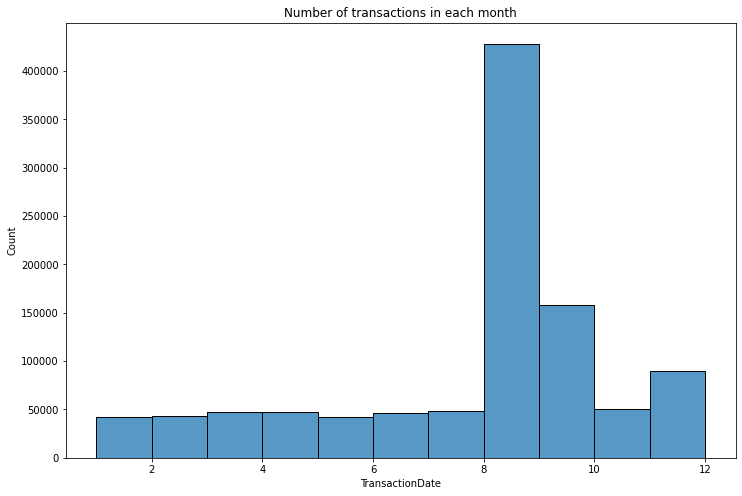

In [388]:
sns.histplot(x = df['TransactionDate'].dt.month, bins = 3, binwidth = 1)
plt.title('Number of transactions in each month')

## Exploratory Data Analysis(EDA)

Skewness of CustAccountBalance: 60.7681591987131
Kurtosis of CustAccountBalance: 5860.139335399748
Distribution Plot of CustAccountBalance:


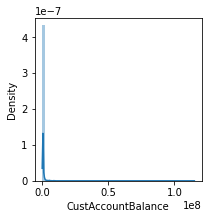

Box Plot of CustAccountBalance:


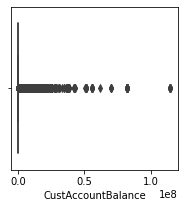

Quantile-Quantile Plot of CustAccountBalance:


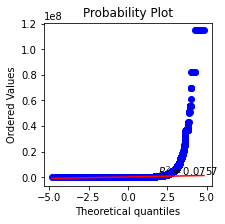

Skewness of TransactionAmount (INR): 47.66842187219132
Kurtosis of TransactionAmount (INR): 6703.751455572876
Distribution Plot of TransactionAmount (INR):


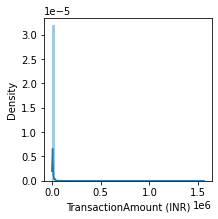

Box Plot of TransactionAmount (INR):


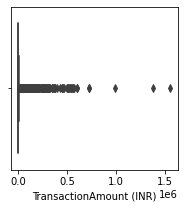

Quantile-Quantile Plot of TransactionAmount (INR):


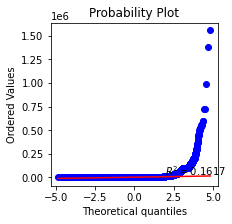

In [389]:
for col in df.columns:
    if df[col].dtypes == np.float64:
        print("Skewness of {}:".format(col),df[col].skew())
        print("Kurtosis of {}:".format(col),df[col].kurt())
        plt.figure(figsize=(3,3))
        print("Distribution Plot of {}:".format(col))
        sns.distplot(df[col])
        plt.show()
        print("Box Plot of {}:".format(col))
        plt.figure(figsize=(3,3))
        sns.boxplot(df[col])
        plt.show()
        print("Quantile-Quantile Plot of {}:".format(col))
        plt.figure(figsize=(3,3))
        probplot(df[col],plot=plt,rvalue=True)
        plt.show()

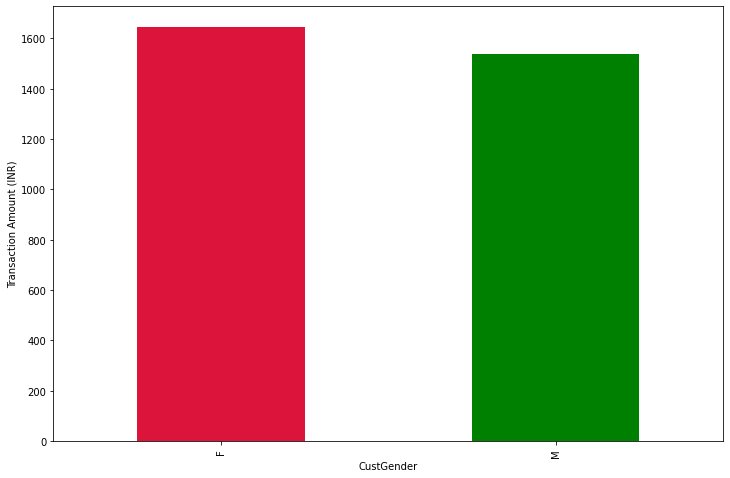

In [390]:
ax = df.groupby('CustGender')['TransactionAmount (INR)'].mean().plot(kind='bar',color=['crimson','green'])
plt.ylabel('Transaction Amount (INR)');

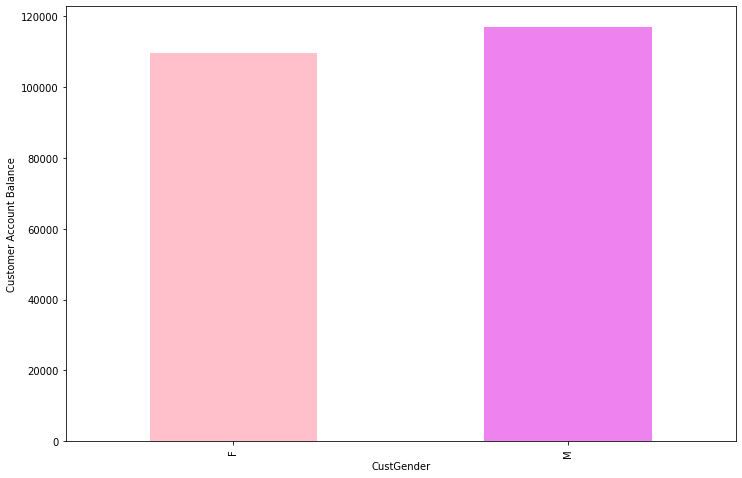

In [391]:
ax = df.groupby('CustGender')['CustAccountBalance'].mean().plot(kind='bar',color=['pink','violet'])
plt.ylabel('Customer Account Balance');

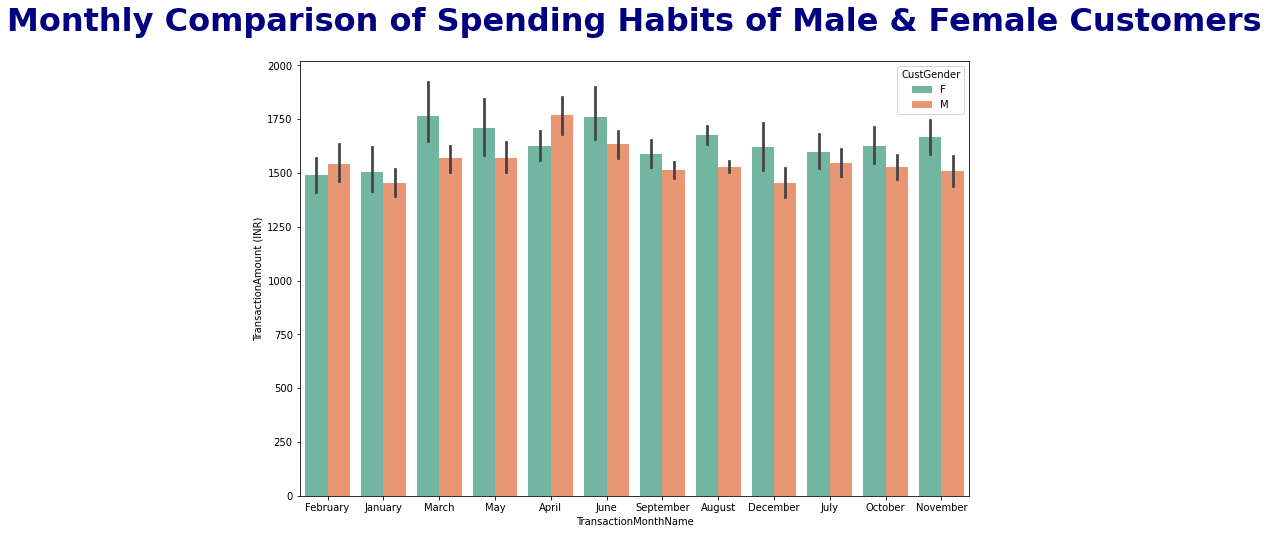

In [392]:
sns.barplot(data=df,x='TransactionMonthName',y='TransactionAmount (INR)',palette='Set2',hue='CustGender')
plt.title('Monthly Comparison of Spending Habits of Male & Female Customers',fontsize=32,fontweight='bold',color='navy',pad=30);

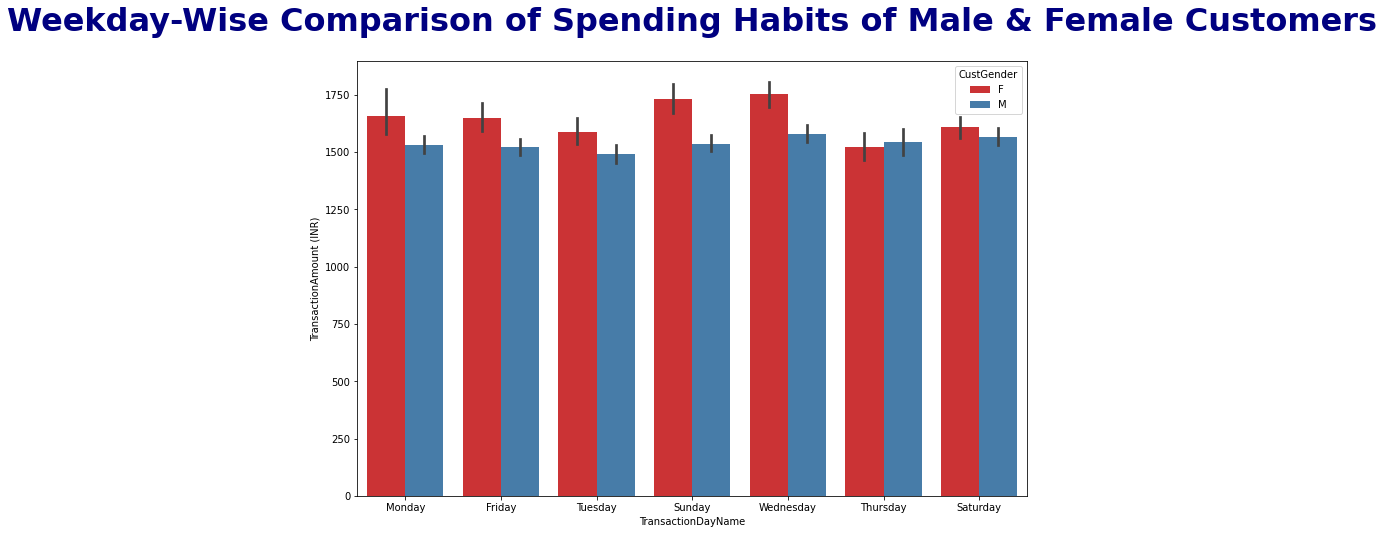

In [393]:
sns.barplot(data=df,x='TransactionDayName',y='TransactionAmount (INR)',palette='Set1',hue='CustGender')
plt.title('Weekday-Wise Comparison of Spending Habits of Male & Female Customers',fontsize=32,fontweight='bold',color='navy',pad=30);

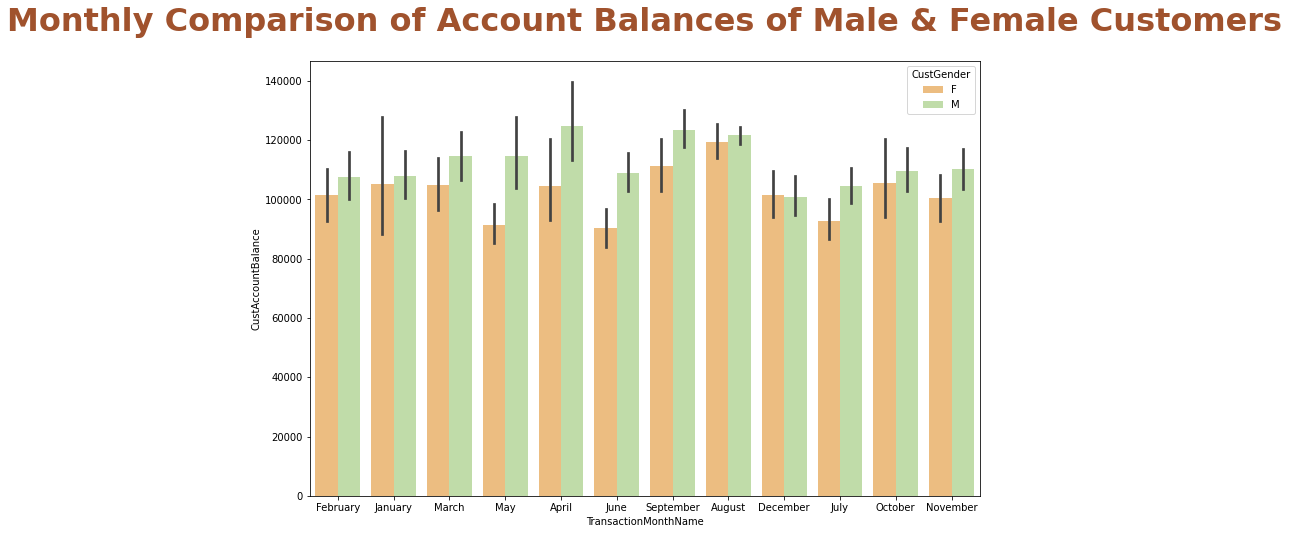

In [394]:
sns.barplot(data=df,x='TransactionMonthName',y='CustAccountBalance',palette='Spectral',hue='CustGender')
plt.title('Monthly Comparison of Account Balances of Male & Female Customers',fontsize=32,fontweight='bold',color='sienna',pad=30);

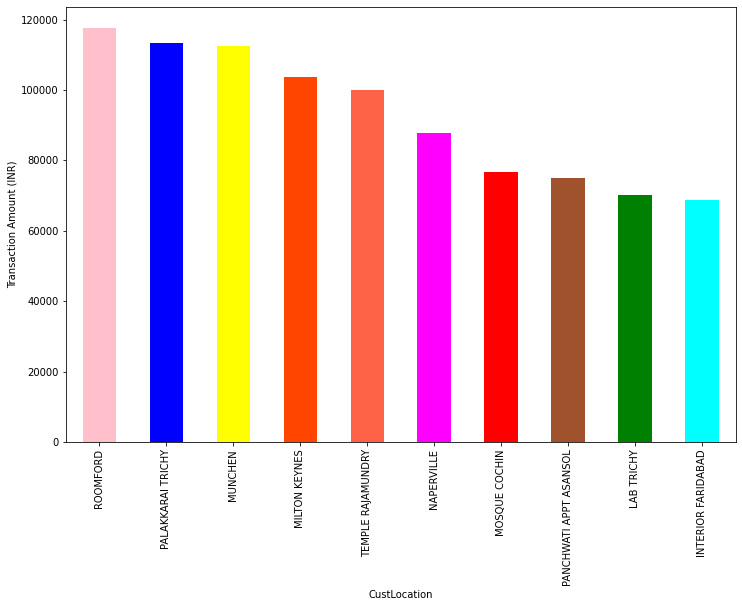

In [395]:
df.groupby('CustLocation')['TransactionAmount (INR)'].mean().sort_values(ascending=False)[:10].plot(kind='bar',color=['pink','blue','yellow','orangered','tomato','magenta','red','sienna','green','cyan'])
plt.ylabel('Transaction Amount (INR)');

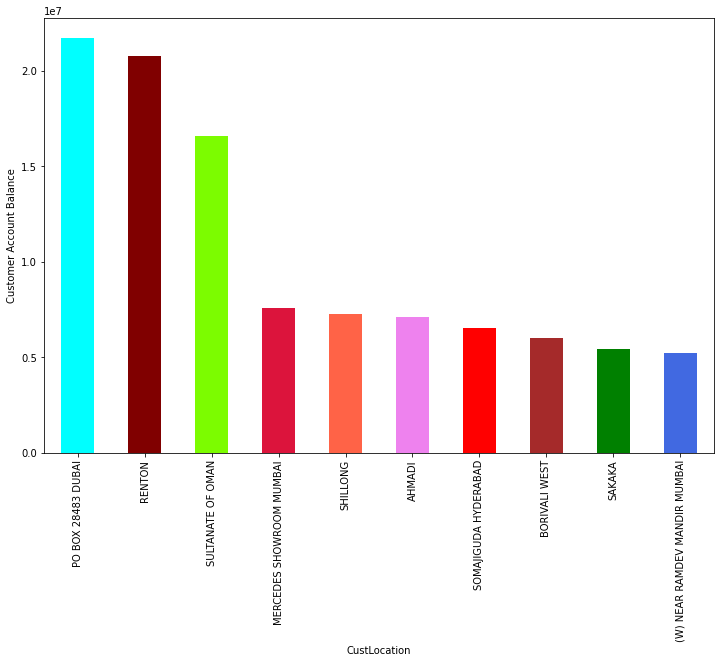

In [396]:
df.groupby('CustLocation')['CustAccountBalance'].mean().sort_values(ascending=False)[:10].plot(kind='bar',color=['aqua','maroon','lawngreen','crimson','tomato','violet','red','brown','green','royalblue'])
plt.ylabel('Customer Account Balance');

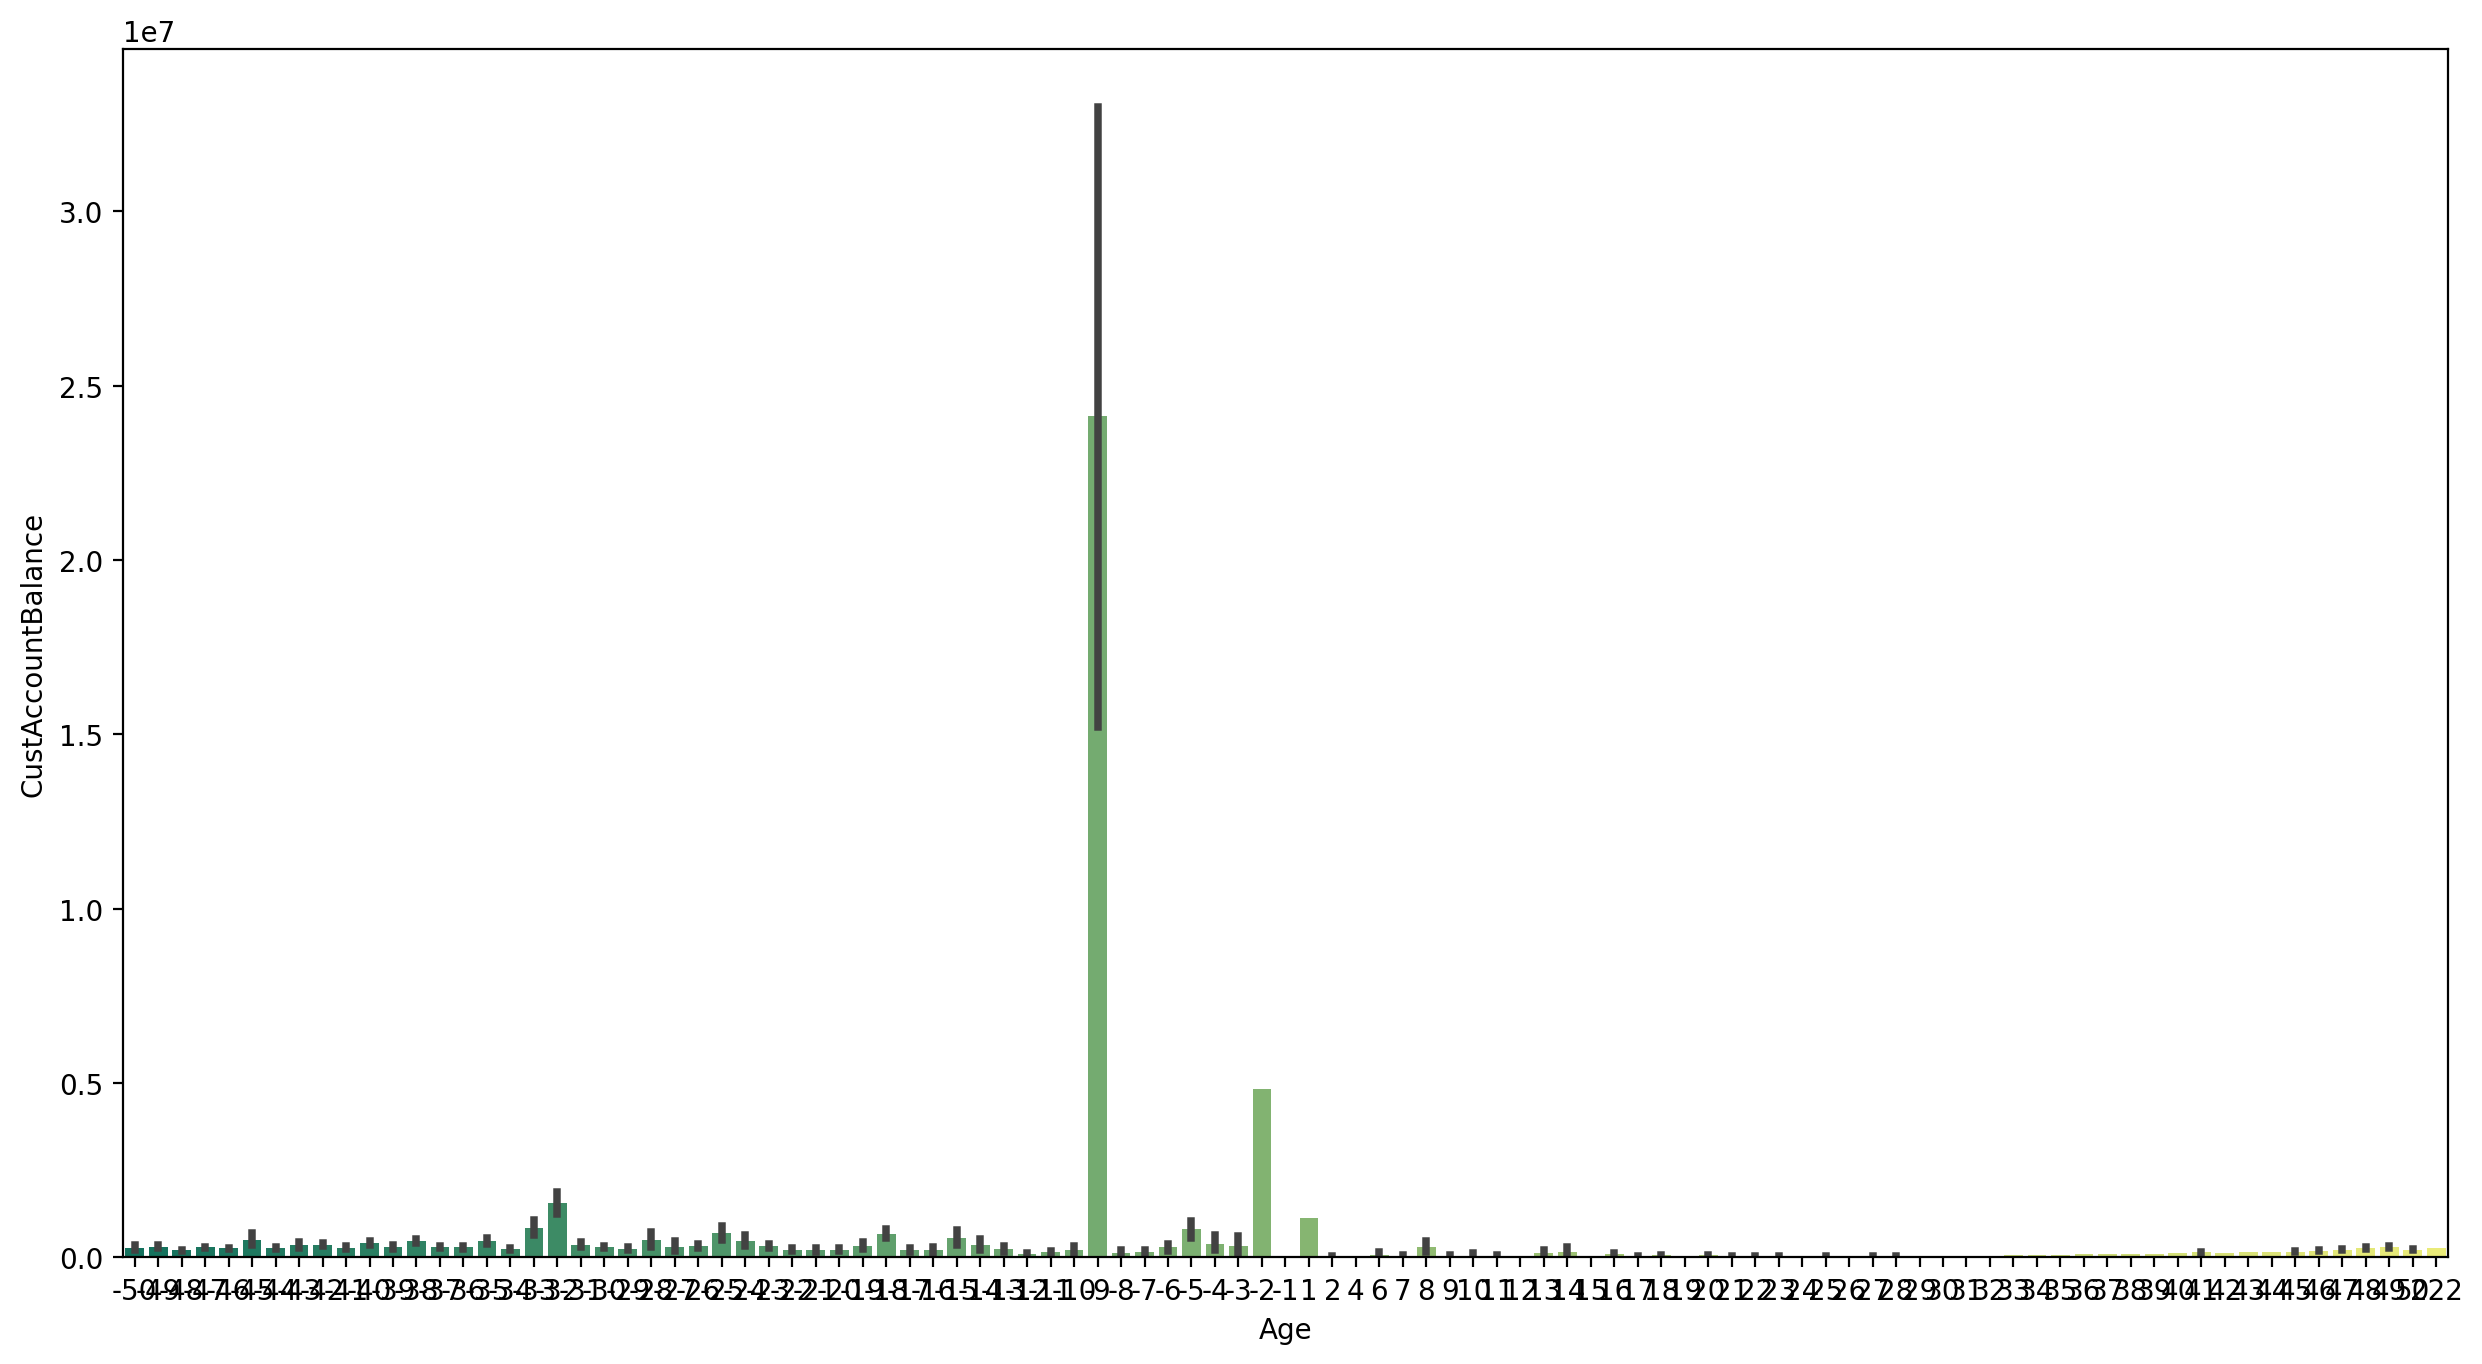

In [397]:
plt.figure(figsize=(15,8),dpi=200)
sns.barplot(data=df,x='Age',y='CustAccountBalance',palette='summer')

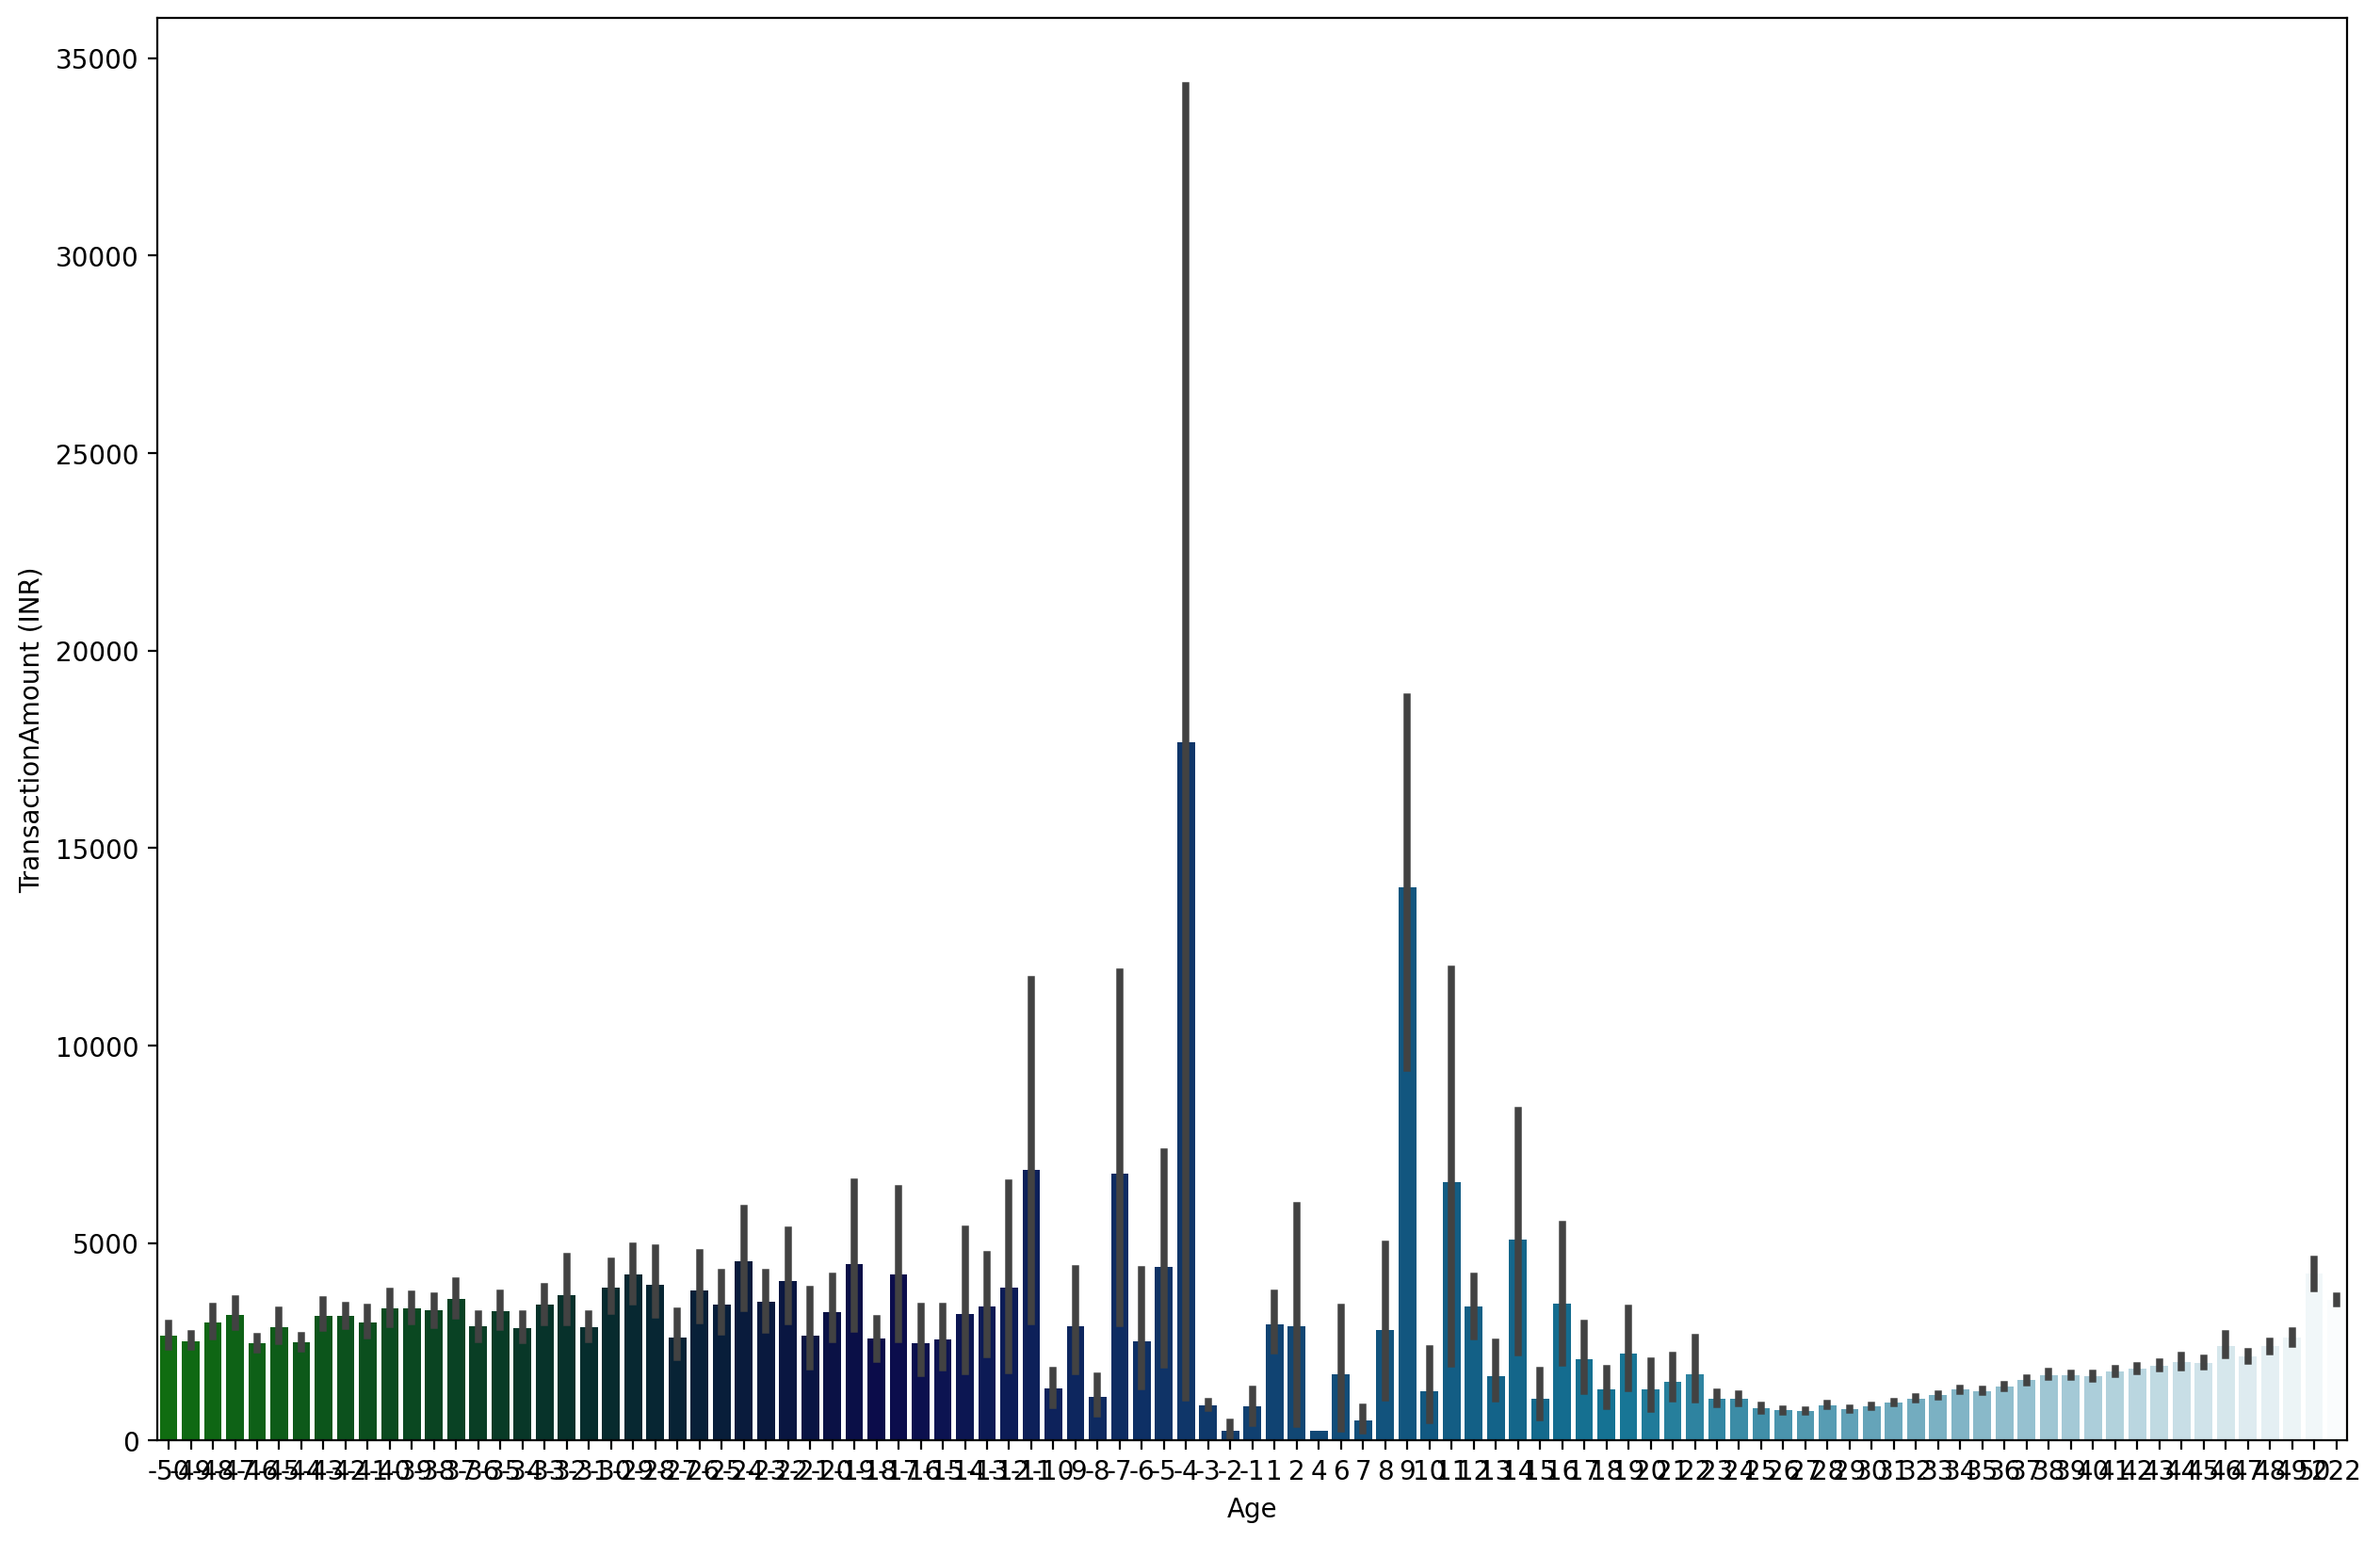

In [398]:
plt.figure(figsize=(15,10),dpi=200)
sns.barplot(data=df,x='Age',y='TransactionAmount (INR)',palette='ocean')

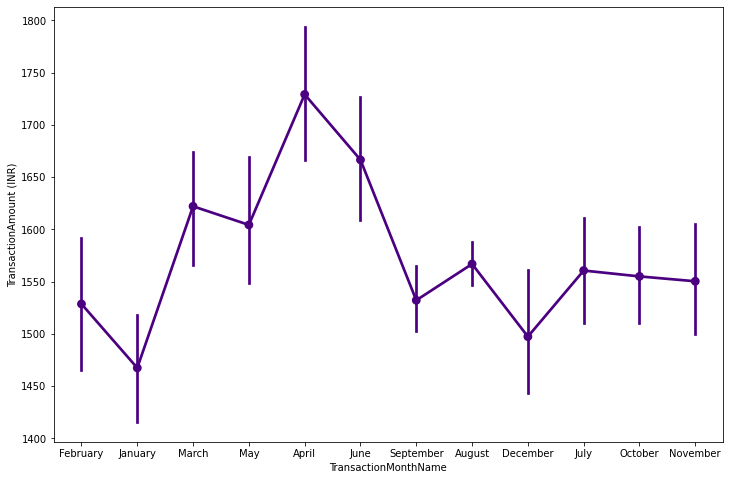

In [399]:
sns.pointplot(data=df,x='TransactionMonthName',y='TransactionAmount (INR)',color='indigo')

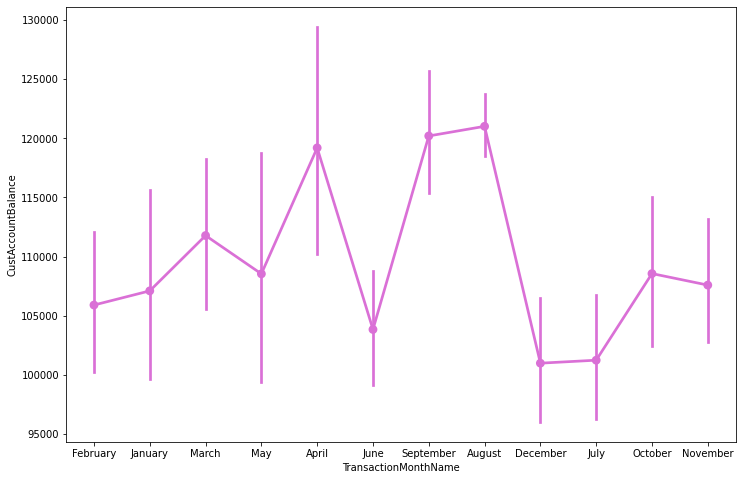

In [400]:
sns.pointplot(data=df,x='TransactionMonthName',y='CustAccountBalance',color='orchid')

In [401]:
df['DaysSinceTransaction'] = (pd.to_datetime('today') - df['TransactionDate'])/np.timedelta64(1, 'D')
df['DaysSinceTransaction'] = df['DaysSinceTransaction'] - df['DaysSinceTransaction'].min()
temp = df[['CustomerID', 'TransactionID']].groupby(by = 'CustomerID', as_index = False, sort = False).count().reset_index()

In [402]:
temp = temp.drop(columns = 'index')
temp.rename(columns = {'TransactionID' : 'TransactionFrequency'})
df = df.merge(right = temp, on = 'CustomerID')
df.head()

,TransactionID_x,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),Age,TransactionMonth,TransactionMonthName,TransactionDay,TransactionDayName,DaysSinceTransaction,TransactionID_y
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,143207,25.00,27,2,February,8,Monday,305.00,1
1,T2,C2142763,2057-04-04,M,JHAJJAR,2270.69,2016-02-08,141858,27999.00,-35,2,February,8,Monday,305.00,1
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,142712,459.00,25,2,February,8,Monday,305.00,1
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-02-08,142714,2060.00,48,2,February,8,Monday,305.00,2
4,T391139,C5342380,1979-05-29,M,MUMBAI,3195.78,2016-08-13,194148,878.40,43,8,August,13,Saturday,118.00,2


In [403]:
df = df.rename(columns = {'TransactionID_y' : 'TransactionFrequency',
                         'DaysSinceTransaction' : 'Recency'})

In [404]:
rmf = df.drop(columns = ['CustGender', 'CustLocation', 'CustLocation',
                         'CustAccountBalance', 'TransactionTime', 'Age']
             ).groupby(by = 'CustomerID').agg({'Recency' : 'min',
                                               'TransactionFrequency': 'first',
                                               'TransactionAmount (INR)' : 'mean'})
df = df.rename(columns = {'TransactionAmount (INR)' : 'AverageTransactionAmount'})
rmf = rmf.rename(columns = {'TransactionAmount (INR)' : 'AverageTransactionAmount'})
rmf.head()

,Recency,TransactionFrequency,AverageTransactionAmount
CustomerID,,,
C1010011,74.00,2,2553.00
C1010012,117.00,1,1499.00
C1010014,154.00,2,727.50
C1010018,85.00,1,30.00
C1010024,113.00,1,5000.00


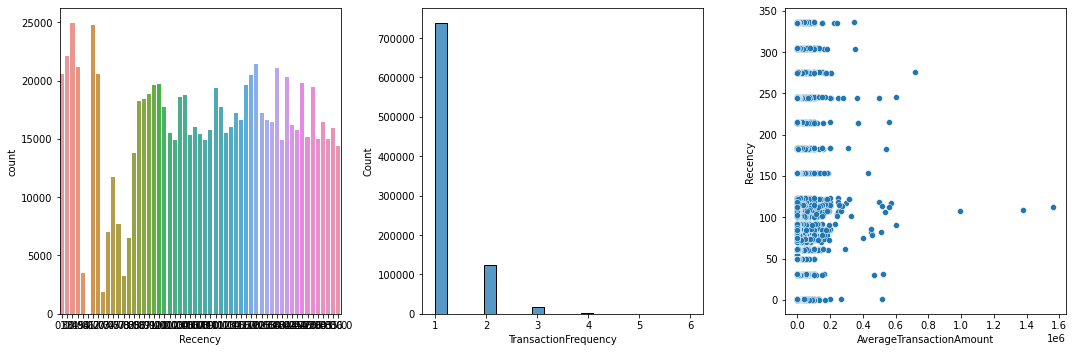

In [405]:
fig, axes = plt.subplots(1, 3, figsize = (15, 5))
axes = axes.flatten()

sns.countplot(x = 'Recency', data = rmf, ax = axes[0])
sns.histplot(x = 'TransactionFrequency', data = rmf, ax = axes[1])
sns.scatterplot(x = 'AverageTransactionAmount', y = 'Recency', data = rmf, ax = axes[2])
plt.tight_layout()

In [406]:
def recency_score(value, quartiles):
    if value < quartiles[0.25]:
        return 4
    if value < quartiles[0.5]:
        return 3
    if value < quartiles[.75]:
        return 2
    else:
        return 1

def monetary_score(value, quartiles):
    if value < quartiles[0.25]:
        return 1
    if value < quartiles[0.5]:
        return 2
    if value < quartiles[0.75]:
        return 3
    else:
        return 4
    
quartiles = rmf.quantile([0.25, 0.5, 0.75]).to_dict()

rmf['recency_score'] = rmf['Recency'].apply(recency_score, quartiles = quartiles['Recency'],)
rmf['frequency_score'] = rmf['TransactionFrequency'].astype(int)
rmf.loc[rmf['frequency_score'] > 4, 'frequency_score'] = 4
rmf['monetary_score'] = rmf['AverageTransactionAmount'].apply(monetary_score, quartiles = quartiles['AverageTransactionAmount'],)
rmf['total_score'] = rmf['recency_score'] + rmf['frequency_score'] + rmf['monetary_score']

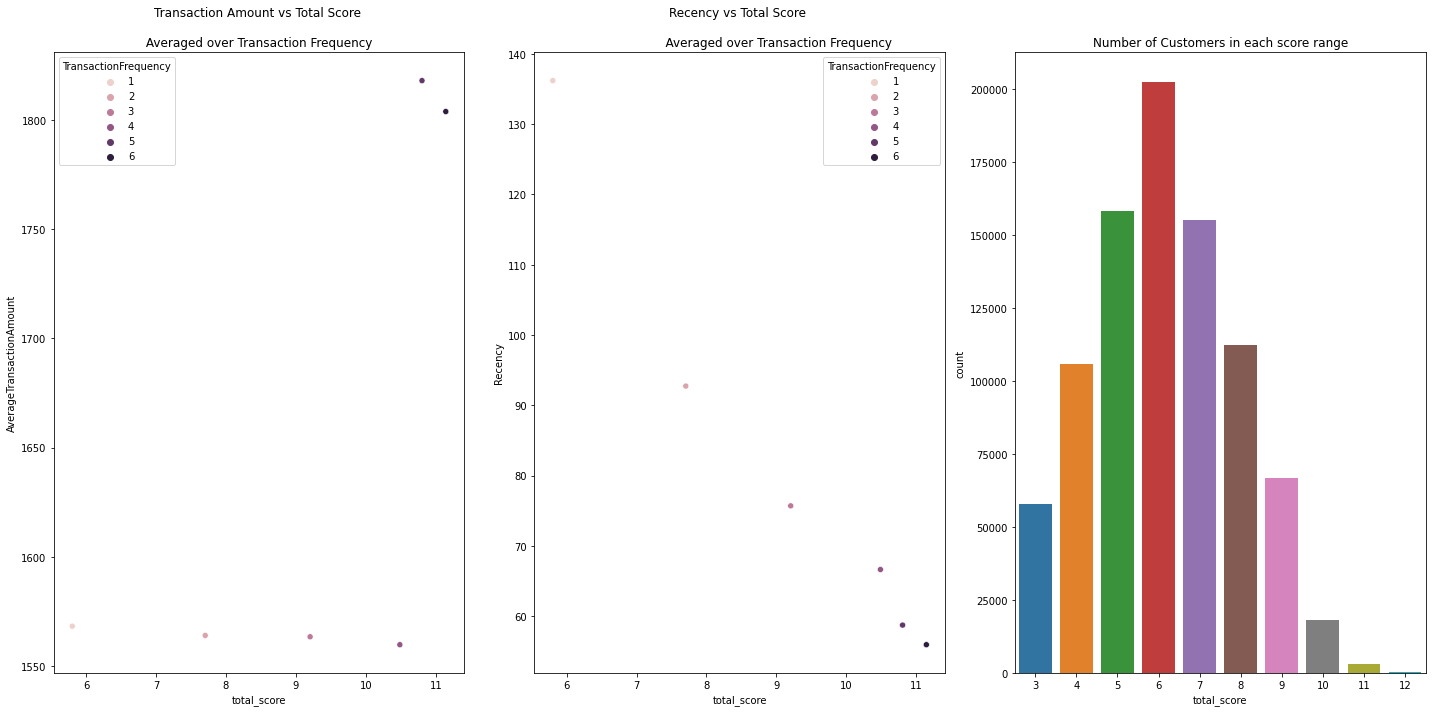

In [407]:
fig, axes = plt.subplots(1, 3, figsize = (20, 10))
axes = axes.flatten()

recency = rmf.groupby(by = 'TransactionFrequency').mean().reset_index()
avg_amount = rmf.groupby(by = 'TransactionFrequency').mean().reset_index()


sns.scatterplot(x = 'total_score', y = 'AverageTransactionAmount', hue = 'TransactionFrequency',
            data = avg_amount, ax = axes[0])
axes[0].set_title('''Transaction Amount vs Total Score 
                  \n Averaged over Transaction Frequency ''')
sns.scatterplot(x = 'total_score', y = 'Recency', data = recency, hue = 'TransactionFrequency',
            ax = axes[1])
axes[1].set_title('''Recency vs Total Score \n
                    Averaged over Transaction Frequency''')
sns.countplot(x = 'total_score', data = rmf, ax = axes[2])
axes[2].set_title('Number of Customers in each score range')
plt.tight_layout()

In [408]:
rmf[rmf.total_score == 12].count()

Recency                     351
TransactionFrequency        351
AverageTransactionAmount    351
recency_score               351
frequency_score             351
monetary_score              351
total_score                 351
dtype: int64

In [409]:
rmf.groupby(by = 'total_score').describe().T

total_score                          3         4         5         6   \
Recency                  count 57969.00 105875.00 158155.00 202557.00   
                         mean    244.79    183.32    155.44    134.13   
                         std      60.90     77.77     74.34     79.89   
                         min     153.00    109.00     86.00      0.00   
                         25%     184.00    115.00    105.00     91.00   
                         50%     245.00    153.00    115.00    111.00   
                         75%     304.00    245.00    214.00    154.00   
                         max     336.00    336.00    336.00    336.00   
TransactionFrequency     count 57969.00 105875.00 158155.00 202557.00   
                         mean      1.00      1.01      1.04      1.08   
                         std       0.00      0.12      0.20      0.28   
                         min       1.00      1.00      1.00      1.00   
                         25%       1.00      1.00      1.00      1.00   
                         50%       1.00      1.00      1.00      1.00   
                         75%       1.00      1.00      1.00      1.00   
                         max       1.00      2.00      3.00      3.00   
AverageTransactionAmount count 57969.00 105875.00 158155.00 202557.00   
                         mean     81.09    198.60    393.14   1728.33   
                         std      51.56    134.17    331.01   6694.59   
                         min       0.00      0.00      0.00      0.00   
                         25%      38.00     84.90    106.00    200.00   
                         50%      76.00    200.00    297.60    500.00   
                         75%     115.00    300.00    600.00   1421.00   
                         max     190.71    499.99   1241.16 720001.16   
recency_score            count 57969.00 105875.00 158155.00 202557.00   
                         mean      1.00      1.47      1.97      2.36   
                         std       0.00      0.50      0.83      1.11   
                         min       1.00      1.00      1.00      1.00   
                         25%       1.00      1.00      1.00      1.00   
                         50%       1.00      1.00      2.00      2.00   
                         75%       1.00      2.00      3.00      3.00   
                         max       1.00      2.00      3.00      4.00   
frequency_score          count 57969.00 105875.00 158155.00 202557.00   
                         mean      1.00      1.01      1.04      1.08   
                         std       0.00      0.12      0.20      0.28   
                         min       1.00      1.00      1.00      1.00   
                         25%       1.00      1.00      1.00      1.00   
                         50%       1.00      1.00      1.00      1.00   
                         75%       1.00      1.00      1.00      1.00   
                         max       1.00      2.00      3.00      3.00   
monetary_score           count 57969.00 105875.00 158155.00 202557.00   
                         mean      1.00      1.52      1.99      2.56   
                         std       0.00      0.50      0.84      1.13   
                         min       1.00      1.00      1.00      1.00   
                         25%       1.00      1.00      1.00      2.00   
                         50%       1.00      2.00      2.00      3.00   
                         75%       1.00      2.00      3.00      4.00   
                         max       1.00      2.00      3.00      4.00   

total_score                            7         8         9         10  \
Recency                  count  155360.00 112429.00  66910.00  18169.00   
                         mean       92.50     77.47     58.54     51.90   
                         std        37.50     34.13     33.92     32.36   
                         min         0.00      0.00      0.00      0.00   
                         25%        82.00     6

## Feature Engineering Continued

In [410]:
df.CustGender.replace(['F','M'],[0,1],inplace=True)
df.CustGender = df.CustGender.astype(np.int64)

## Categorical Encoding

In [411]:
encoder = LabelEncoder()
df.CustLocation = encoder.fit_transform(df.CustLocation)
df.CustLocation = df.CustLocation.astype(np.int64)
#locations = df.CustLocation.unique()
#locations = {place : idx for idx, place in enumerate(locations)}
#df['CustLocation'] = df['CustLocation'].map(locations)

In [412]:
df.head()

,TransactionID_x,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,AverageTransactionAmount,Age,TransactionMonth,TransactionMonthName,TransactionDay,TransactionDayName,Recency,TransactionFrequency
0,T1,C5841053,1994-10-01,0,3557,17819.05,2016-02-08,143207,25.00,27,2,February,8,Monday,305.00,1
1,T2,C2142763,2057-04-04,1,3618,2270.69,2016-02-08,141858,27999.00,-35,2,February,8,Monday,305.00,1
2,T3,C4417068,1996-11-26,0,5219,17874.44,2016-02-08,142712,459.00,25,2,February,8,Monday,305.00,1
3,T4,C5342380,1973-09-14,0,5219,866503.21,2016-02-08,142714,2060.00,48,2,February,8,Monday,305.00,2
4,T391139,C5342380,1979-05-29,1,5219,3195.78,2016-08-13,194148,878.40,43,8,August,13,Saturday,118.00,2


In [413]:
df_cluster =df.drop(['CustomerID','CustomerDOB','TransactionDate','TransactionTime','TransactionMonthName','TransactionDayName','TransactionMonth','TransactionDay'],axis=1,inplace=True)

In [414]:
df_cluster = df.loc[df.CustLocation == 3058]
#df_cluster.value_counts()
df.loc[df.CustLocation].value_counts()

TransactionID_x  CustGender  CustLocation  CustAccountBalance  AverageTransactionAmount  Age  Recency  TransactionFrequency
T3859            0           3058          62933.86            720.00                    34   78.00    1                       102267
T480348          0           5219          9663.74             205.00                    39   111.00   2                        84344
T709817          0           2876          18442.09            360.00                    45   275.00   2                        81416
T2268            1           770           7633.68             210.00                    31   49.00    2                        73666
T702343          1           8080          80013.83            49.00                     28   101.00   2                        70751
                                                                                                                                ...  
T1925            1           2876          12281.63            297.00   

## Feature Scaling

In [415]:
scaler = StandardScaler()
ct = ColumnTransformer([('Standard Scaling', scaler, 
                    ['CustAccountBalance', 'AverageTransactionAmount',
                    'Age', 'Recency'])], remainder = 'passthrough')
X = df_cluster.drop(columns = ['TransactionID_x', 'CustLocation'])
X = ct.fit_transform(X)

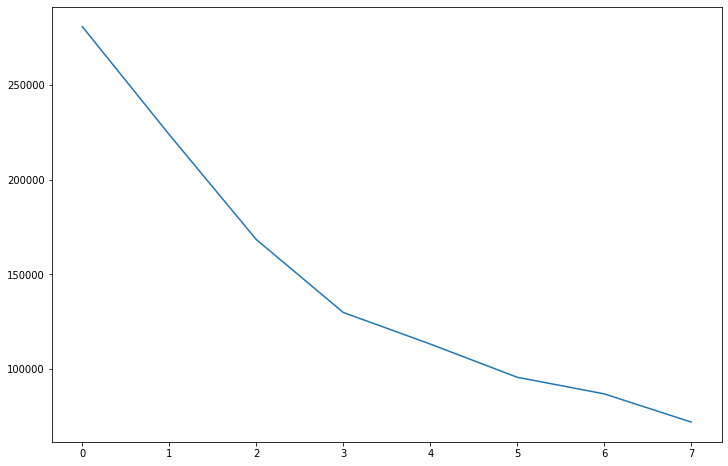

In [416]:
# elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 10]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(X)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd)

In [417]:
clusters = range(2, 8)

In [418]:
def plt_silhouette(clusters, clusterer):
    #This silhouette analysis is from SKLearn : https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
    for cluster in clusters:
        fig, ax = plt.subplots(1, 1, figsize = (10, 10))

        ax.set_xlim([0, 1])
        ax.set_ylim([0, len(X) + (cluster + 1) * 10])
        
        if clusterer == MiniBatchKMeans:
            md = MiniBatchKMeans(n_clusters = cluster)
            preds = md.fit_predict(X)
            md_name = 'MiniBatchKMeans'
        else:
            md = GaussianMixture(n_components = cluster)
            preds = md.fit_predict(X)
            md_name = 'GaussianMixture'
        
        sil_average = silhouette_score(X, preds)
        print(f'For {cluster} clusters,\n the average silhouette score is {sil_average}')
        sample_sil = silhouette_samples(X, preds)
        y_lower = 10

        for i in range(cluster):
            cluster_sil = sample_sil[preds == i]
            cluster_sil.sort()
            size_cluster = cluster_sil.shape[0]
            y_upper = y_lower + size_cluster
            color = cm.nipy_spectral(float(i) / cluster)
            ax.fill_betweenx(np.arange(y_lower, y_upper),
                            0,
                            cluster_sil,
                            facecolor = color,
                            edgecolor = color)
            ax.text(-0.05, y_lower + 0.5 * size_cluster, str(i))
            y_lower = y_upper + 10
            ax.axvline(x = sil_average, color = 'red', linestyle = '--')
            ax.set_yticks([])
            ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
            ax.set_title(f'Silhouette analysis using {md_name} for {cluster} clusters', fontweight = 'bold')

For 2 clusters,
 the average silhouette score is 0.6337090956601668
For 3 clusters,
 the average silhouette score is 0.41604061735597614
For 4 clusters,
 the average silhouette score is 0.3884877723763764
For 5 clusters,
 the average silhouette score is 0.31155673318324506
For 6 clusters,
 the average silhouette score is 0.3050067192104961
For 7 clusters,
 the average silhouette score is 0.3674722161810304


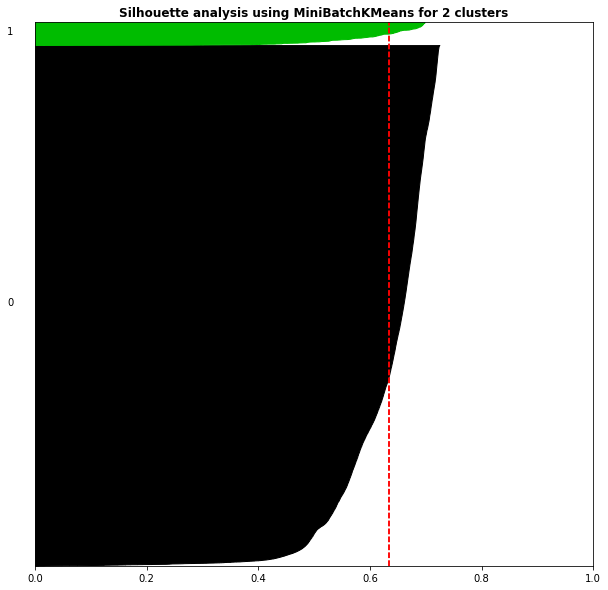

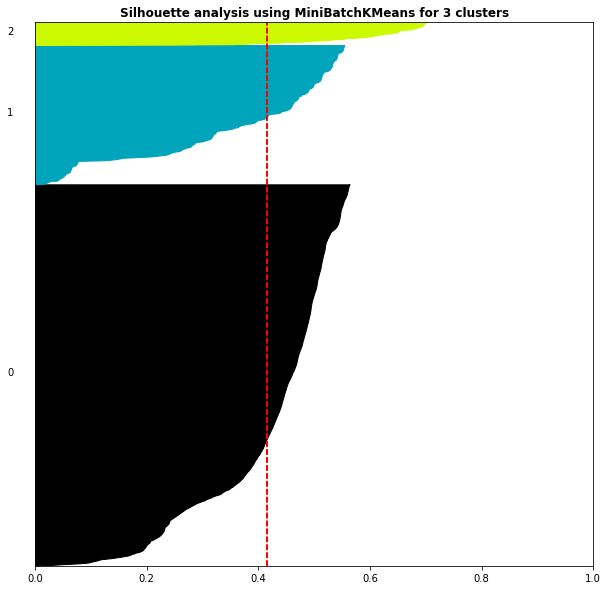

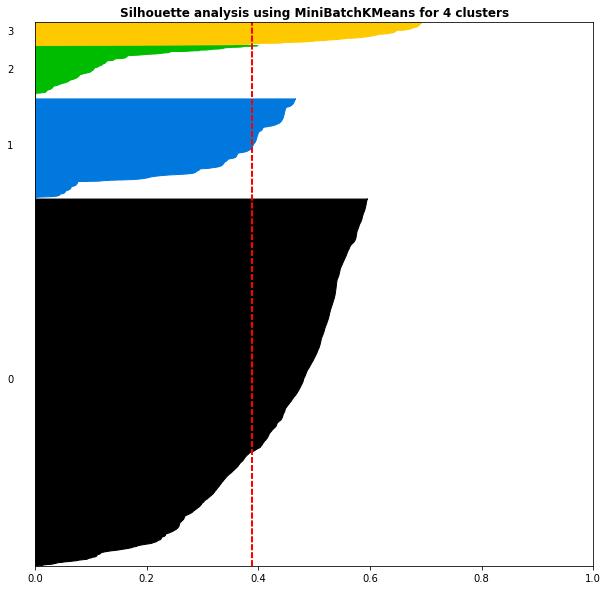

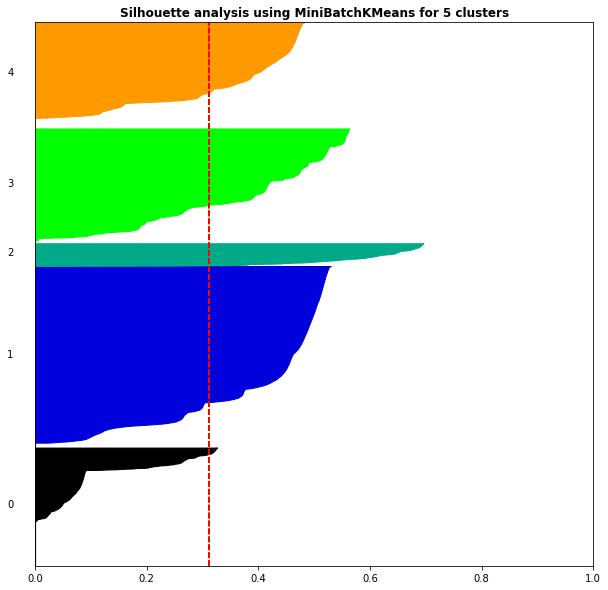

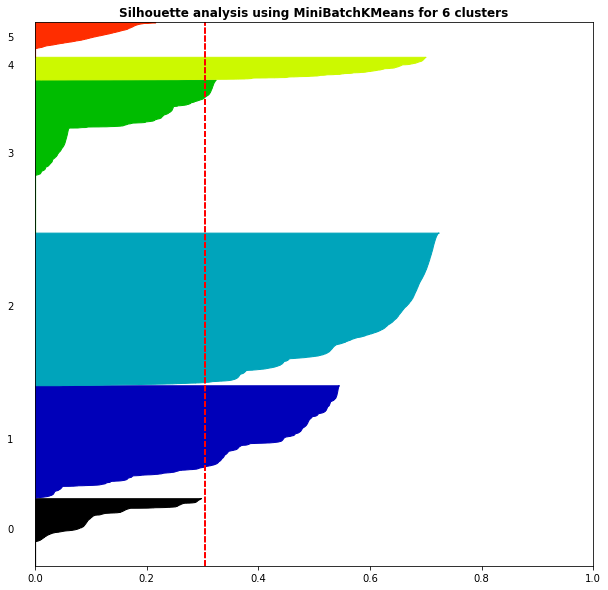

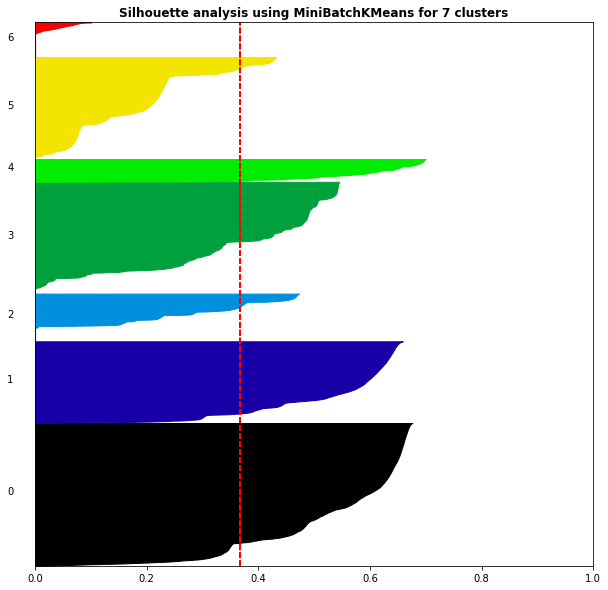

In [419]:
plt_silhouette(clusters, MiniBatchKMeans)

For 2 clusters,
 the average silhouette score is 0.31264156322327724
For 3 clusters,
 the average silhouette score is 0.2107310438748364
For 4 clusters,
 the average silhouette score is 0.03908207664592993
For 5 clusters,
 the average silhouette score is 0.1705918299685917
For 6 clusters,
 the average silhouette score is 0.1296470209953382
For 7 clusters,
 the average silhouette score is 0.22247204046569585


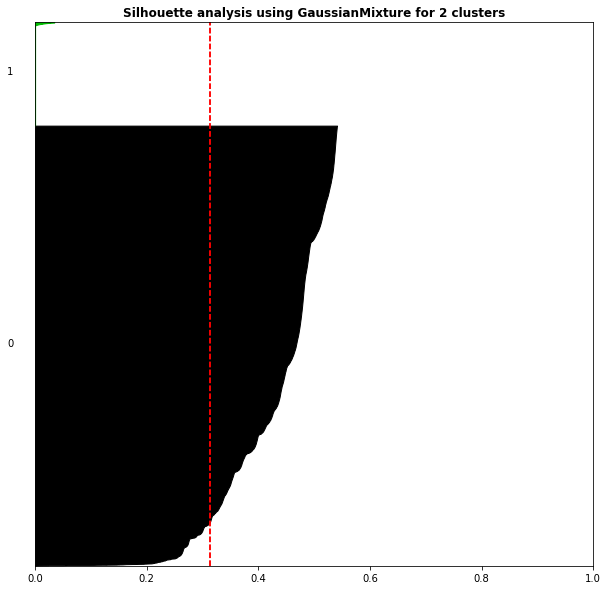

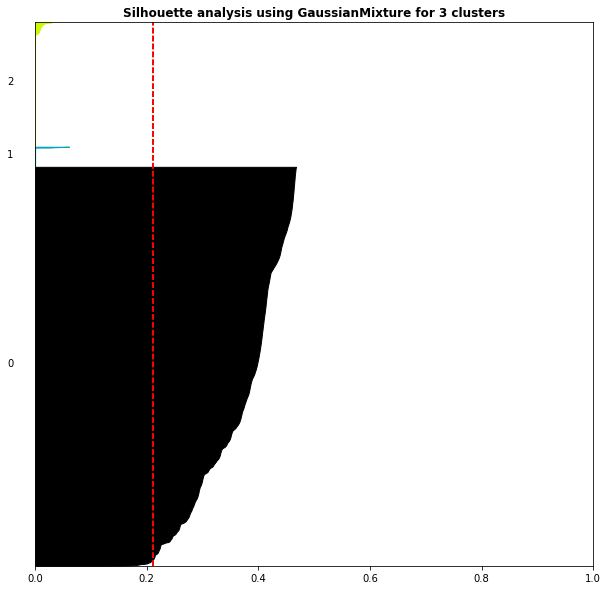

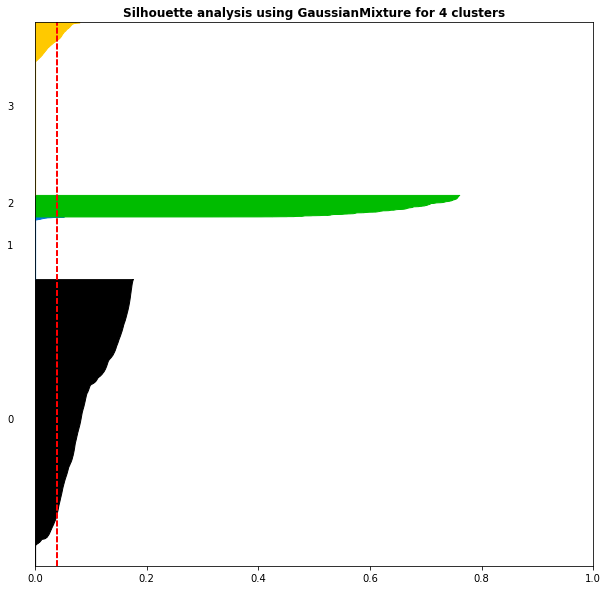

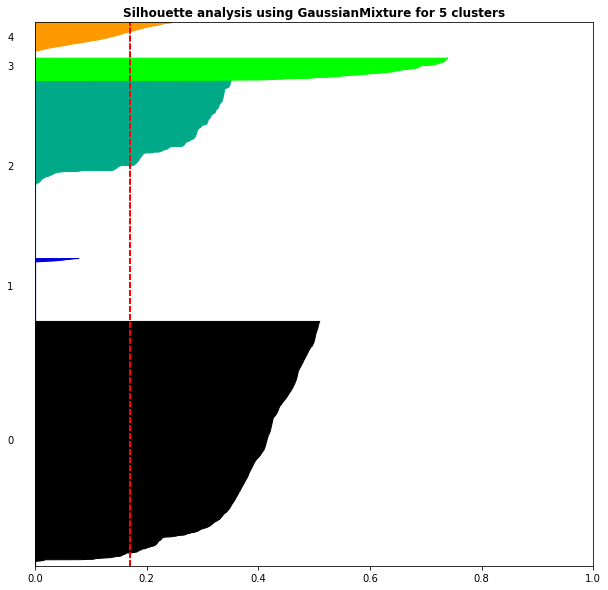

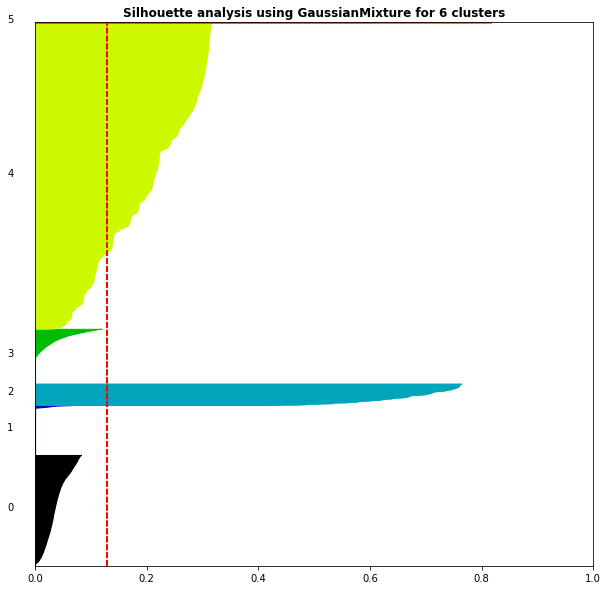

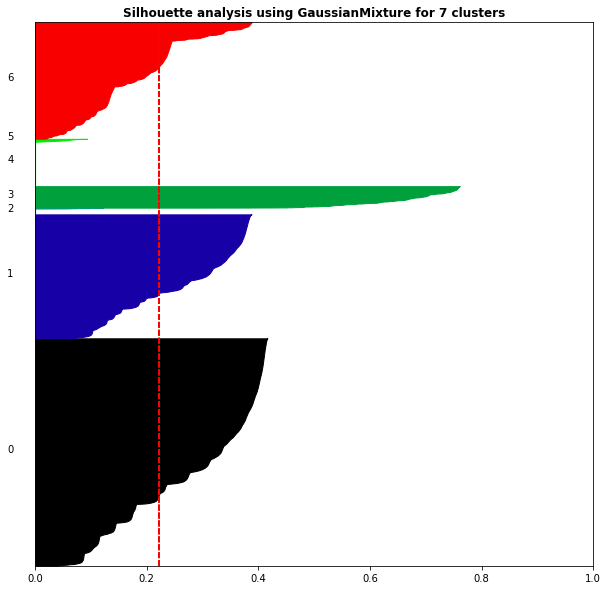

In [420]:
plt_silhouette(clusters, GaussianMixture)

In [421]:
km3 = MiniBatchKMeans(n_clusters = 3)
km4 = MiniBatchKMeans(n_clusters = 4)

df_cluster['Three_Clusters'] = km3.fit_predict(X)
df_cluster['Four_Clusters'] = km4.fit_predict(X)

df_cluster.head()

,TransactionID_x,CustGender,CustLocation,CustAccountBalance,AverageTransactionAmount,Age,Recency,TransactionFrequency,Three_Clusters,Four_Clusters
12,T9,0,3058,14906.96,833.00,34,305.00,1,1,2
29,T25,0,3058,2951.10,1892.00,31,276.00,1,1,2
30,T26,1,3058,3297.74,242.00,29,276.00,1,2,2
39,T35,1,3058,39.73,110.00,45,276.00,1,2,2
58,T51,0,3058,298357.41,1388.00,40,215.00,1,1,2


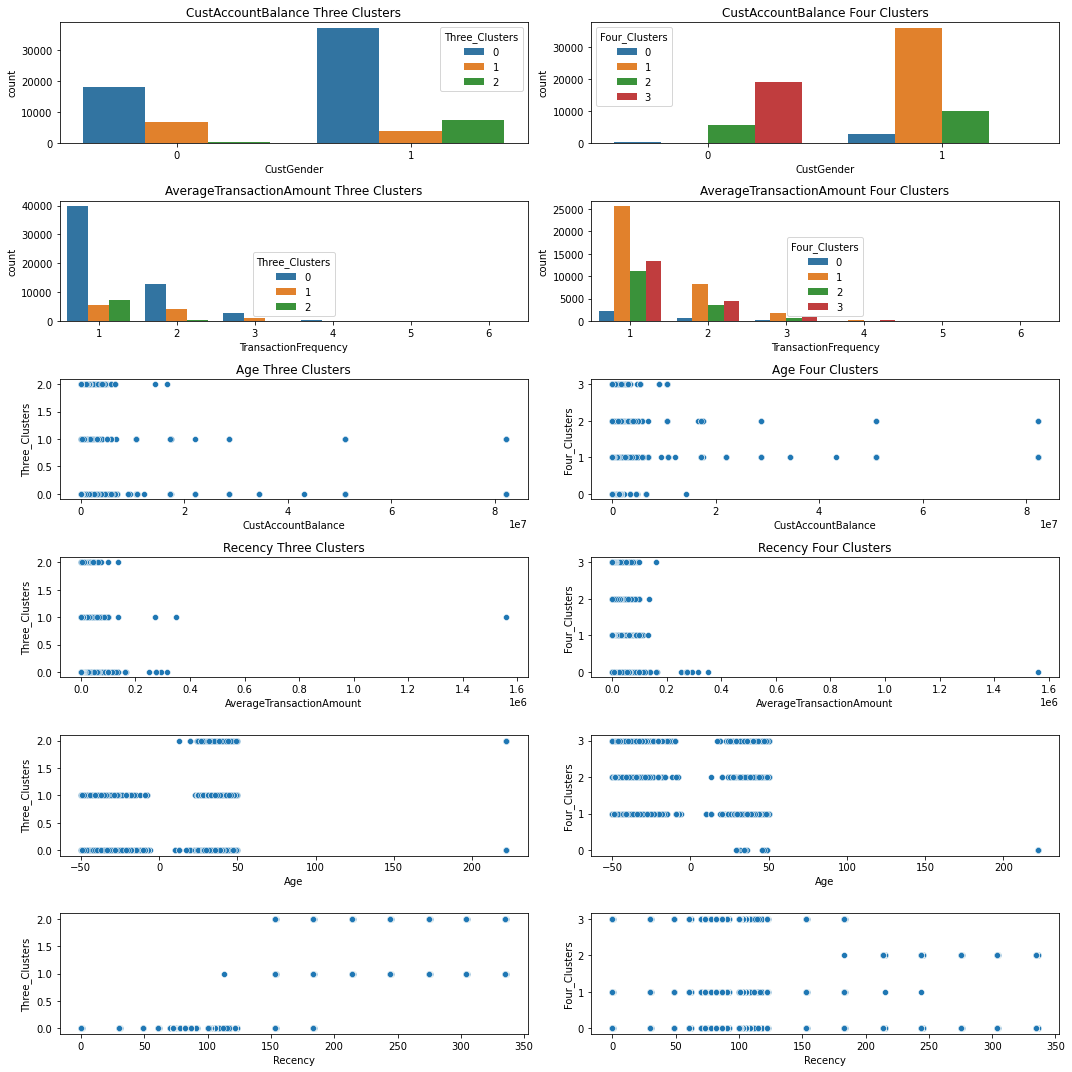

In [422]:
df_cluster['TransactionFrequency'] = df_cluster['TransactionFrequency'].astype(int)
fig, axes = plt.subplots(6, 2, figsize = (15, 15))
axes = axes.flatten()

continuous_columns = df_cluster.drop(columns = ['TransactionID_x','CustLocation', 'Three_Clusters',
                                                'Four_Clusters', 'CustGender', 'TransactionFrequency']).columns

cat_columns = df_cluster[['CustGender', 'TransactionFrequency']]

for idx, c_name in enumerate(cat_columns):
    sns.countplot(x = c_name, hue = 'Three_Clusters',  data = df_cluster, ax = axes[2 * idx])
    sns.countplot(x = c_name, hue = 'Four_Clusters', data = df_cluster, ax = axes[2 * idx + 1])
    axes[2 * idx].set_title(f'{c_name} Three Clusters')
    axes[2 * idx + 1].set_title(f'{c_name} Four Clusters')

for idx, c_name in enumerate(continuous_columns):
    sns.scatterplot(y = 'Three_Clusters', x = c_name,  data = df_cluster, ax = axes[2 * (idx + 2)])
    sns.scatterplot(y = 'Four_Clusters', x = c_name, data = df_cluster, ax = axes[2 * (idx + 2) + 1])
    axes[2 * idx].set_title(f'{c_name} Three Clusters')
    axes[2 * idx + 1].set_title(f'{c_name} Four Clusters')
    
plt.tight_layout()